In [1]:
reset -sf

In [2]:
import numpy as np
import pandas as pd
from scipy import stats
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
def posterior_distribution(alpha,beta):
    #x: probability/rate
    #y: probability density function
    
    #updating posterior distribution
    i = 0
    if i != len(alpha):
        pos_alpha, pos_beta = alpha[i] + alpha[i+1], beta[i] + beta[i+1]
        i+=1
    return pos_alpha,pos_beta

x = x = np.linspace(0., 1, 1000) #random probability

def plot_with_fill(x, y, label):
    #x: probability/rate
    #y: probability density function
    lines = plt.plot(x, y, label=label, lw=2)
    plt.fill_between(x, 0, y, alpha=0.2, color=lines[0].get_c())

# Crime Dataset

In [4]:
crime = pd.read_csv('data/crime.csv')
crime.columns = [column.lower() for column in crime.columns]

In [5]:
crime.head(5)

,dates,category,descript,dayofweek,pddistrict,resolution,address,x,y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [6]:
crime.pddistrict.unique()

array(['NORTHERN', 'PARK', 'INGLESIDE', 'BAYVIEW', 'RICHMOND', 'CENTRAL',
       'TARAVAL', 'TENDERLOIN', 'MISSION', 'SOUTHERN'], dtype=object)

In [7]:
'Selected District'
crime = crime[crime.pddistrict.isin(['RICHMOND','MISSION','BAYVIEW','TENDERLOIN'])]

In [8]:
crime.tail(2)

,dates,category,descript,dayofweek,pddistrict,resolution,address,x,y
878043,2003-01-06 00:20:00,OTHER OFFENSES,PAROLE VIOLATION,Monday,BAYVIEW,"ARREST, BOOKED",1500 Block of SHAFTER AV,-122.389769,37.730564
878048,2003-01-06 00:01:00,FORGERY/COUNTERFEITING,"CHECKS, FORGERY (FELONY)",Monday,BAYVIEW,NONE,1800 Block of NEWCOMB AV,-122.394926,37.738212


In [9]:
crimedf = pd.DataFrame()
crimedf['datetime'] = pd.to_datetime(crime.dates)
crimedf['date'] = crimedf.datetime.apply(lambda x: x.date())
crimedf['id'] = crimedf.index
crimedf['category'] = crime.category
crimedf['district'] = crime.pddistrict
crimedf['crimeperday'] = crimedf.groupby('date')['id'].transform('count')
crimedf['crimeperdistrict'] = crimedf.groupby(['date','district'])['district'].transform('count')
crimedf = crimedf.drop(['datetime','category','id'],axis = 1).reset_index(drop=True)
crimedf = crimedf.drop_duplicates().reset_index(drop=True)

In [10]:
crimedf.head(2)

,date,district,crimeperday,crimeperdistrict
0,2015-05-13,BAYVIEW,115,30
1,2015-05-13,RICHMOND,115,19


In [11]:
bayview = crimedf[crimedf.district == 'BAYVIEW'].reset_index(drop = True)
richmond = crimedf[crimedf.district == 'RICHMOND'].reset_index(drop = True)
tenderloin = crimedf[crimedf.district == 'TENDERLOIN'].reset_index(drop = True)
mission = crimedf[crimedf.district == 'MISSION'].reset_index(drop = True)

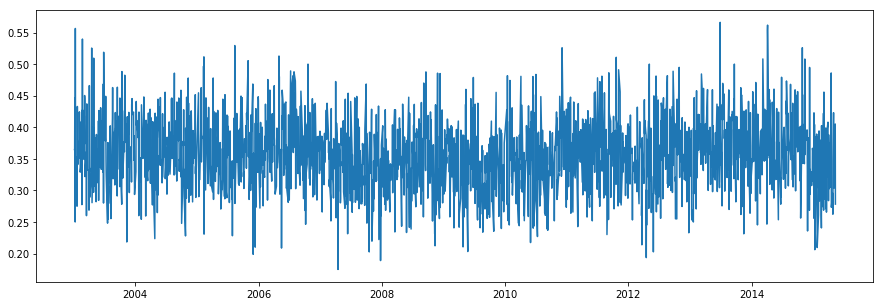

In [12]:
mission['crimerate'] = mission['crimeperdistrict']/ mission['crimeperday']
plt.figure(figsize = (15,5))
plt.plot(mission['date'],mission['crimerate'])

### Fit in Beta Distribution

In [13]:
bayview_pos_alpha,bayview_pos_beta = posterior_distribution(bayview.crimeperdistrict,(bayview.crimeperday - bayview.crimeperdistrict))
richmond_pos_alpha,richmond_pos_beta = posterior_distribution(richmond.crimeperdistrict,(richmond.crimeperday - richmond.crimeperdistrict))
tenderloin_pos_alpha,tenderloin_pos_beta = posterior_distribution(tenderloin.crimeperdistrict,(tenderloin.crimeperday - tenderloin.crimeperdistrict))
mission_pos_alpha,mission_pos_beta = posterior_distribution(mission.crimeperdistrict,(mission.crimeperday - mission.crimeperdistrict))

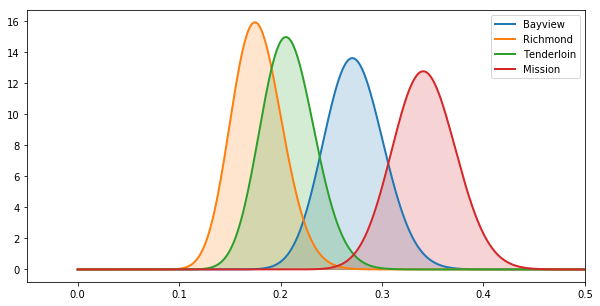

In [14]:
# generating pdf
bayviewpdf = stats.beta.pdf(x, bayview_pos_alpha, bayview_pos_beta )
richmondpdf = stats.beta.pdf(x, richmond_pos_alpha, richmond_pos_beta )
tenderloinpdf = stats.beta.pdf(x, tenderloin_pos_alpha, tenderloin_pos_beta)
missionpdf = stats.beta.pdf(x, mission_pos_alpha, mission_pos_beta)

plt.figure(5, figsize = (10,5))
plot_with_fill(x, bayviewpdf, 'Bayview')
plot_with_fill(x, richmondpdf, 'Richmond')
plot_with_fill(x, tenderloinpdf, 'Tenderloin')
plot_with_fill(x, missionpdf, 'Mission')
# plot_with_fill(x, siteE_beta, 'ingleside')


plt.xlim(xmax=.5)
plt.legend()
plt.show()

# Calculate Expected Crime Rate

In [15]:
def get_mean(alpha,beta):
    mean, var, skew, kurt = stats.beta.stats(alpha, beta, moments='mvsk')
    return float(mean)

In [16]:
bayview_mean = get_mean(bayview_pos_alpha, bayview_pos_beta )
richmond_mean = get_mean(richmond_pos_alpha, richmond_pos_beta )
tenderloin_mean = get_mean( tenderloin_pos_alpha, tenderloin_pos_beta)
mission_mean = get_mean(mission_pos_alpha, mission_pos_beta)

In [17]:
print('\n')
print('--------Bayesian Rate--------')
print(f'Bayview {(bayview_mean):.3} - Richmond {(richmond_mean):.3}')
print(f'Tenderloin {(tenderloin_mean):.3} - Mission {(mission_mean):.3}')
print('\n')



--------Bayesian Rate--------
Bayview 0.273 - Richmond 0.177
Tenderloin 0.208 - Mission 0.342




In [18]:
def get_mean_dataset(df):
    mean2015 = df.crimeperdistrict[0]/df.crimeperday[0]
    mean2003 = df.crimeperdistrict[-1:].values/df.crimeperday[-1:].values
    meanoverall = df.crimeperdistrict.sum()/df.crimeperday.sum()
    print(f'Rate in 2003: {mean2003[0]:.3} - Rate in 2015: {mean2015:.3} - Overall Rate: {meanoverall:.3}')
    #return mean2003[0], mean2015,meanoverall

In [19]:
print('\n')

print('----Mission----')
get_mean_dataset(mission)
print('\n')
print('----Tenderloin----')
print('\n')
get_mean_dataset(tenderloin)
print('----Richmond----')
print('\n')
get_mean_dataset(richmond)
print('\n')
print('----Bayview----')
get_mean_dataset(bayview)
print('\n')




----Mission----
Rate in 2003: 0.365 - Rate in 2015: 0.278 - Overall Rate: 0.356


----Tenderloin----


Rate in 2003: 0.188 - Rate in 2015: 0.296 - Overall Rate: 0.243
----Richmond----


Rate in 2003: 0.153 - Rate in 2015: 0.165 - Overall Rate: 0.134


----Bayview----
Rate in 2003: 0.294 - Rate in 2015: 0.261 - Overall Rate: 0.266




## Calculate Confidence Interval

In [20]:
confidence_level = .95
mission_ci_lower = stats.beta.ppf(1-confidence_level, mission_pos_alpha, mission_pos_beta)
mission_ci_upper = stats.beta.ppf(confidence_level, mission_pos_alpha, mission_pos_beta)

print(f"Mission Crimate Rate is: [{mission_ci_lower:.2} - {mission_ci_upper:.2}] with {confidence_level:.1%} confidence")


Mission Crimate Rate is: [0.29 - 0.39] with 95.0% confidence


In [21]:
confidence_level = .95
richmond_ci_lower = stats.beta.ppf(1-confidence_level, richmond_pos_alpha, richmond_pos_beta)
richmond_ci_upper = stats.beta.ppf(confidence_level, richmond_pos_alpha, richmond_pos_beta)

print(f"Richmond Crimate Rate is: [{richmond_ci_lower:.2} - {richmond_ci_upper:.2}] with {confidence_level:.1%} confidence")


Richmond Crimate Rate is: [0.14 - 0.22] with 95.0% confidence


In [22]:
confidence_level = .95
tenderloin_ci_lower = stats.beta.ppf(1-confidence_level,tenderloin_pos_alpha, tenderloin_pos_beta)
tenderloin_ci_upper = stats.beta.ppf(confidence_level, tenderloin_pos_alpha, tenderloin_pos_beta)

print(f"Tenderloin Crimate Rate is: [{tenderloin_ci_lower:.2} - {tenderloin_ci_upper:.2}] with {confidence_level:.1%} confidence")


Tenderloin Crimate Rate is: [0.17 - 0.25] with 95.0% confidence


# Overall Stats

<img src="image/crimerate.png">
<img src="image/crimerate0.png">


### Overall, we can see that criminal rate in the Mission is generally decreasing overtime. However it isnt very clear with the ovearll rate. The advantage of Bayesian approach is that it weighted on recency. The most recent value will have the highest weights. It also gives out a more narror confidence interval comparing to the traditional statistical approach.

### With given confidence interval, the safest day in the Mission is still much worse than the craziest day in the Tenderloin. So if you want to use the stats for either real estate investment or researching on what area to move to, the Bayesian mean and CI will be incredibly helpful

# Taxi

In [23]:
def convert_datatype(df):
    df['pick_up_date'] = df['pick_up_date'].apply(pd.to_datetime)
    df['number_of_trips'] = df['number_of_trips'].apply(lambda x: x.replace(',',''))
    df['number_of_vehicles'] = df['number_of_vehicles'].apply(lambda x: x.replace('-',''))
    df['number_of_vehicles'] = df['number_of_vehicles'].apply(lambda x: x.replace('    ','0'))
    df[['number_of_vehicles','number_of_trips']] = df[['number_of_vehicles','number_of_trips']].apply(pd.to_numeric)
#     df['total_trips_perday'] = df.groupby('pick_up_date')['number_of_trips'].transform('sum')
#     df['pickuprate'] = df['number_of_vehicles'] / df['number_of_trips']
    return df

In [24]:
df = pd.read_csv('data/other-FHV-services_jan-aug-2015.csv')
df.columns = [column.lower().replace(' ','_') for column in df.columns]
df = df.fillna(0)

In [25]:
df = convert_datatype(df)
base = ['B00310','B00256','B02653','B01315','B00248']
df = df[df.base_number.isin(base)].reset_index(drop=True)

In [26]:
df['total_trips_perday'] = df.groupby('pick_up_date')['number_of_trips'].transform('sum')
df['pick_up_rate'] = df.number_of_trips/df.total_trips_perday

In [27]:
df.head(5)

,base_number,base_name,pick_up_date,number_of_trips,number_of_vehicles,total_trips_perday,pick_up_rate
0,B00248,YELLOWSTONE TRANSPORTATION INC.,2015-01-01,1137,106,5941,0.191382
1,B00310,WATSON CAR SERVICE INC.,2015-01-01,1792,119,5941,0.301633
2,B01315,"V.I.T. CAR SERVICE, INC.",2015-01-01,1234,120,5941,0.207709
3,B02653,NEW COLLEGE CAR SVCE INC,2015-01-01,1778,84,5941,0.299276
4,B00248,YELLOWSTONE TRANSPORTATION INC.,2015-01-02,1008,129,5419,0.186012


In [28]:
base = ['B00310','B00256','B02653','B01315','B00248']

In [29]:
A = df[df.base_number == 'B00310'].reset_index(drop=True)
B = df[df.base_number == 'B00256'].reset_index(drop=True)
C = df[df.base_number == 'B02653'].reset_index(drop=True)
D = df[df.base_number == 'B01315'].reset_index(drop=True)


In [30]:
A_pos_alpha,A_pos_beta = posterior_distribution(A.number_of_trips,A.total_trips_perday - A.number_of_trips)
B_pos_alpha,B_pos_beta = posterior_distribution(B.number_of_trips,B.total_trips_perday - B.number_of_trips)
C_pos_alpha,C_pos_beta = posterior_distribution(C.number_of_trips,C.total_trips_perday - C.number_of_trips)
D_pos_alpha,D_pos_beta = posterior_distribution(D.number_of_trips,D.total_trips_perday - D.number_of_trips)

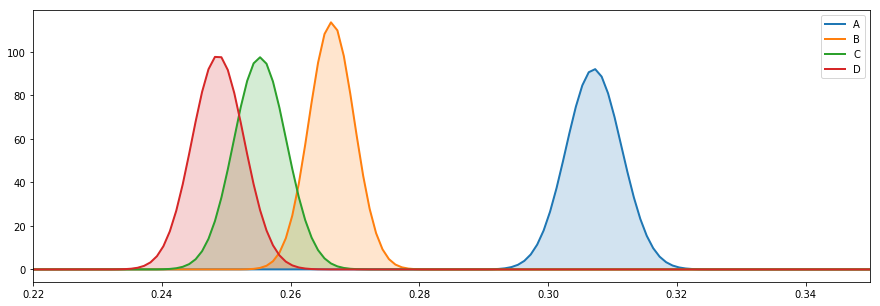

In [31]:
Apdf = stats.beta.pdf(x,A_pos_alpha,A_pos_beta)
Bpdf = stats.beta.pdf(x,B_pos_alpha,B_pos_beta)
Cpdf = stats.beta.pdf(x,C_pos_alpha,C_pos_beta)
Dpdf = stats.beta.pdf(x,D_pos_alpha,D_pos_beta)

plt.figure(4, figsize = (15,5))
plot_with_fill(x, Apdf, 'A')
plot_with_fill(x, Bpdf, 'B')
plot_with_fill(x, Cpdf, 'C')
plot_with_fill(x, Dpdf, 'D')

plt.xlim(xmax=.35,xmin = 0.22)
plt.legend()
plt.show()

# Calculated Expected Pickup Rate

In [32]:
A_mean = get_mean(A_pos_alpha,A_pos_beta)
B_mean = get_mean(B_pos_alpha,B_pos_beta)
C_mean = get_mean(C_pos_alpha,C_pos_beta)
D_mean = get_mean(D_pos_alpha,D_pos_beta)

In [33]:
print('\n')
print('--------Bayesian Rate--------')
print(f'A_mean {(A_mean):.3} - B_mean {(B_mean):.3}')
print(f'C_mean {(C_mean):.3} - D_mean {(D_mean):.3}')
print('\n')



--------Bayesian Rate--------
A_mean 0.307 - B_mean 0.266
C_mean 0.255 - D_mean 0.249




In [34]:
def get_mean_dataset(df):
    meanJan = df.pick_up_rate[0]
    meanMay = df.pick_up_rate[-1:].values
    meanoverall = df.number_of_trips.sum()/df.total_trips_perday.sum()
    print(f'Rate in Jan15: {meanJan:.3} - Rate in May15: {meanMay[0]:.3} - Overall Rate: {meanoverall:.3}')


In [35]:
print('\n')
print('----A----')
get_mean_dataset(A)
print('\n')
print('----B----')
get_mean_dataset(B)
print('\n')
print('----C----')
get_mean_dataset(C)
print('\n')
print('----D----')
get_mean_dataset(D)
print('\n')




----A----
Rate in Jan15: 0.302 - Rate in May15: 0.356 - Overall Rate: 0.265


----B----
Rate in Jan15: 0.222 - Rate in May15: 0.34 - Overall Rate: 0.328


----C----
Rate in Jan15: 0.299 - Rate in May15: 0.421 - Overall Rate: 0.209


----D----
Rate in Jan15: 0.208 - Rate in May15: 0.175 - Overall Rate: 0.219




In [36]:
confidence_level = .95
A_ci_lower = stats.beta.ppf(1-confidence_level, A_pos_alpha, A_pos_beta)
A_ci_upper = stats.beta.ppf(confidence_level, A_pos_alpha, A_pos_beta)
B_ci_lower = stats.beta.ppf(1-confidence_level, B_pos_alpha,B_pos_beta)
B_ci_upper = stats.beta.ppf(confidence_level, B_pos_alpha,B_pos_beta)
C_ci_lower = stats.beta.ppf(1-confidence_level, C_pos_alpha, C_pos_beta)
C_ci_upper = stats.beta.ppf(confidence_level, C_pos_alpha, C_pos_beta)

print(f"Pickup Rate at company A is: [{A_ci_lower:.2} - {A_ci_upper:.2}] with {confidence_level:.1%} confidence")
print(f"Pickup Rate at company B is: [{B_ci_lower:.2} - {B_ci_upper:.2}] with {confidence_level:.1%} confidence")
print(f"Pickup Rate at company C is: [{C_ci_lower:.2} - {C_ci_upper:.2}] with {confidence_level:.1%} confidence")


Pickup Rate at company A is: [0.3 - 0.31] with 95.0% confidence
Pickup Rate at company B is: [0.26 - 0.27] with 95.0% confidence
Pickup Rate at company C is: [0.25 - 0.26] with 95.0% confidence


<img src="image/pickuprate.png">

<img src="image/pickuprate0.png">
